In [ ]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
import os
# Load environment variables from a .env file
load_dotenv()

# Fetch sensitive details from environment variables
azure_endpoint = os.getenv("AZURE_ENDPOINT")
openai_api_key = os.getenv("OPENAI_API_KEY")
deployment_name = os.getenv("DEPLOYMENT_NAME")
openai_api_version = os.getenv("OPENAI_API_VERSION")

# Define remaining kwargs
kwargs = {
    "azure_endpoint": azure_endpoint,
    "openai_api_version": openai_api_version,
    "openai_api_type": "azure",
    "openai_api_key": openai_api_key,
    "deployment_name": deployment_name,
    "request_timeout": 45.0,
    "max_retries": 1,
    "temperature": 0.0,
    "seed": 123,
    "streaming": True,
}

# Initialize the LLM
llm = AzureChatOpenAI(**kwargs)


In [5]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

messages = [AIMessage(content = "So you were saying you were god?", name="AI")]
messages.append(HumanMessage(content="Yes I was saying I'm God, I run this shizzzz", name="God"))
messages.append(AIMessage(content="Ok God. Why did the chicken cross the road? ", name='AI'))
messages.append(HumanMessage(content= "To neutralize the entropy of the Universe", name="God"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: AI

So you were saying you were god?
================================ Human Message =================================
Name: God

Yes I was saying I'm God, I run this shizzzz
================================== Ai Message ==================================
Name: AI

Ok God. Why did the chicken cross the road?
================================ Human Message =================================
Name: God

To neutralize the entropy of the Universe


In [8]:
result = llm.invoke(messages)
result.response_metadata

{'finish_reason': 'stop', 'model_name': 'gpt-4-32k'}

In [9]:
def multiply(a: int, b:int)-> int:
    """
    This is a multiply function taking inputs a and b
    Args:   
        a: the first integer
        b: the second integer
    """
    return a*b

llm_with_tools = llm.bind_tools([multiply])


In [11]:
# now we are going to see a tool call

tool_call = llm_with_tools.invoke([HumanMessage(content='These two numbers are given 3, and 5, and the results is a numerical computation, of the \
                                                multiplicative variety')])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_h0JoG7i4hSFo2ZCbfvGjDZFc', 'function': {'arguments': '{\n  "a": 3,\n  "b": 5\n}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-32k'}, id='run-3666126f-776a-4ddf-a74c-e606f91ffc92-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 5}, 'id': 'call_h0JoG7i4hSFo2ZCbfvGjDZFc', 'type': 'tool_call'}])

In [15]:
tool_call.additional_kwargs['tool_calls'][0]['function']['arguments']

'{\n  "a": 3,\n  "b": 5\n}'

## Message States as a list

In [ ]:
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages, MessagesState

class MessagesStateCustom(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# we can defined messages as a list of AnyMessage and add_message as reducer function, which is just going to append
# or we can also use the built in MessagesState class in langgraph which just defines something like our custom 
# implementation. It defines a list called messages, and it has add_messages as a reducer function





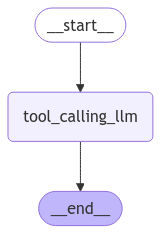

In [17]:
# let's build a graph with what we have learned
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(MessagesState)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_edge(START, 'tool_calling_llm')
builder.add_edge('tool_calling_llm', END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [24]:
result = graph.invoke({'messages': [HumanMessage(content="Write me the result of multiplication 3, 4 ")]})
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Write me the result of multiplication 3, 4 
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sf1RkyaS6Ob2ZUzARUWWFInB)
 Call ID: call_sf1RkyaS6Ob2ZUzARUWWFInB
  Args:
    a: 3
    b: 4


In [27]:
result = graph.invoke({'messages': [HumanMessage(content="Write a joke about James Bond 007's mental illness")]})
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Write a joke about James Bond 007's mental illness
================================== Ai Message ==================================

Why did James Bond 007 start seeing a therapist?

Because he couldn't handle his "double-O"CD!
